In [37]:
# Some standard import statements that are nice for Jupyter

# this is necessary for the functions.py file to be imported
# replace the path with the appropriate path to your workspace
import sys
sys.path.append('/ucn/orithyia_data/psi_transmission/scripts')
sys.path.append('/Users/jonahbd/psi_transmission/scripts')


import os
import logging
import ipynb
import decimal
from lmfit import Model
import time
import numpy as np
from scipy.optimize import curve_fit
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# prevents the need to reload the kernel everytime functions.py file is updated
%load_ext autoreload
%autoreload 2

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

# importing functions for analysis
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# loading the data sets

# main detector
data_dict, norm_dict = load_all_main()

In [3]:
# monitor detector
monitor_data = load_monitor()

In [4]:
# 2 second proton beam current
p_beam_2s = load_p_beam_2s()

In [5]:
# 10 second proton beam current
p_beam_10s = load_p_beam_10s()

# Measuring Pre-Storage Lifetime for Various Configurations

The function used to fit the pre-storage data is:

$$\large{N(t) = N_0 \cdot e^{\frac{-t}{\tau}}}$$

where $\tau$ is the characteristic pre-storage decay time to be extracted.

NOMI: dof = 96, redchi = 22.594008815002656
JPTI: dof = 107, redchi = 2.4316839478156225
JPSU: dof = 15, redchi = 28.60516486956536
DISK: dof = 12, redchi = 7.585565797292446
GD01: dof = 112, redchi = 1.1108280296713937
GD03: dof = 14, redchi = 3.0135321395662453
EPSU: dof = 45, redchi = 1.1218768380305568


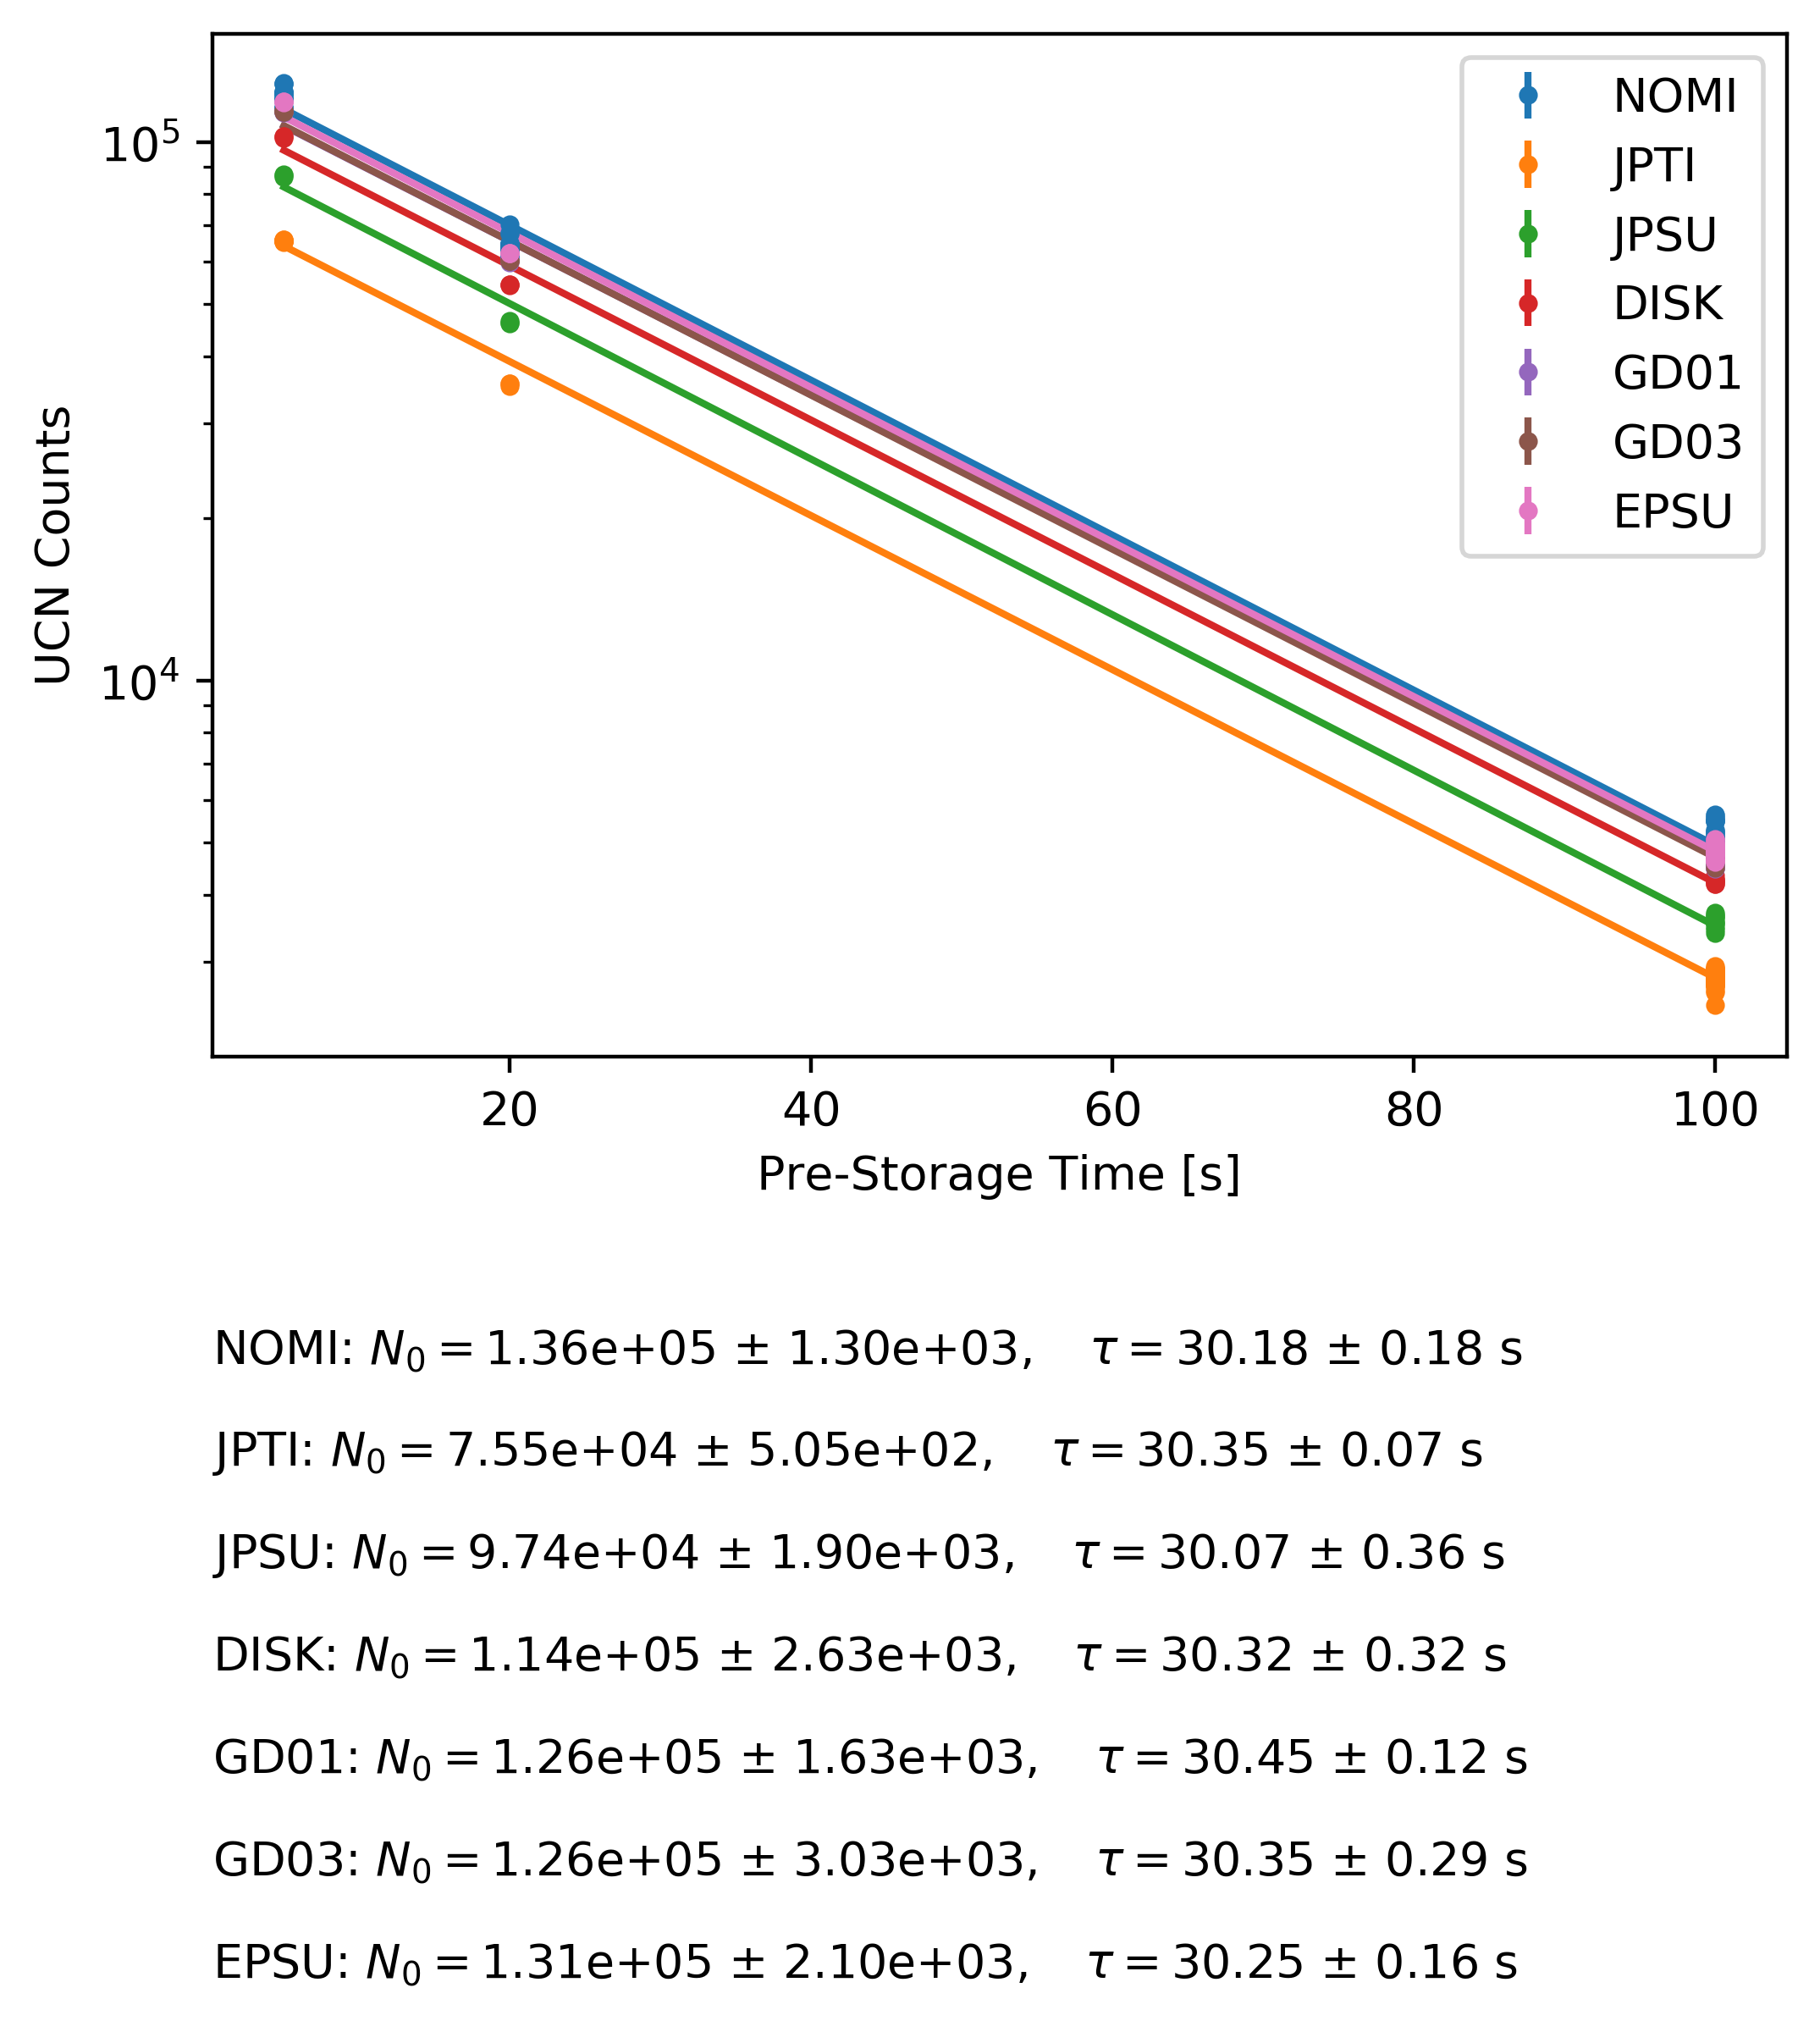

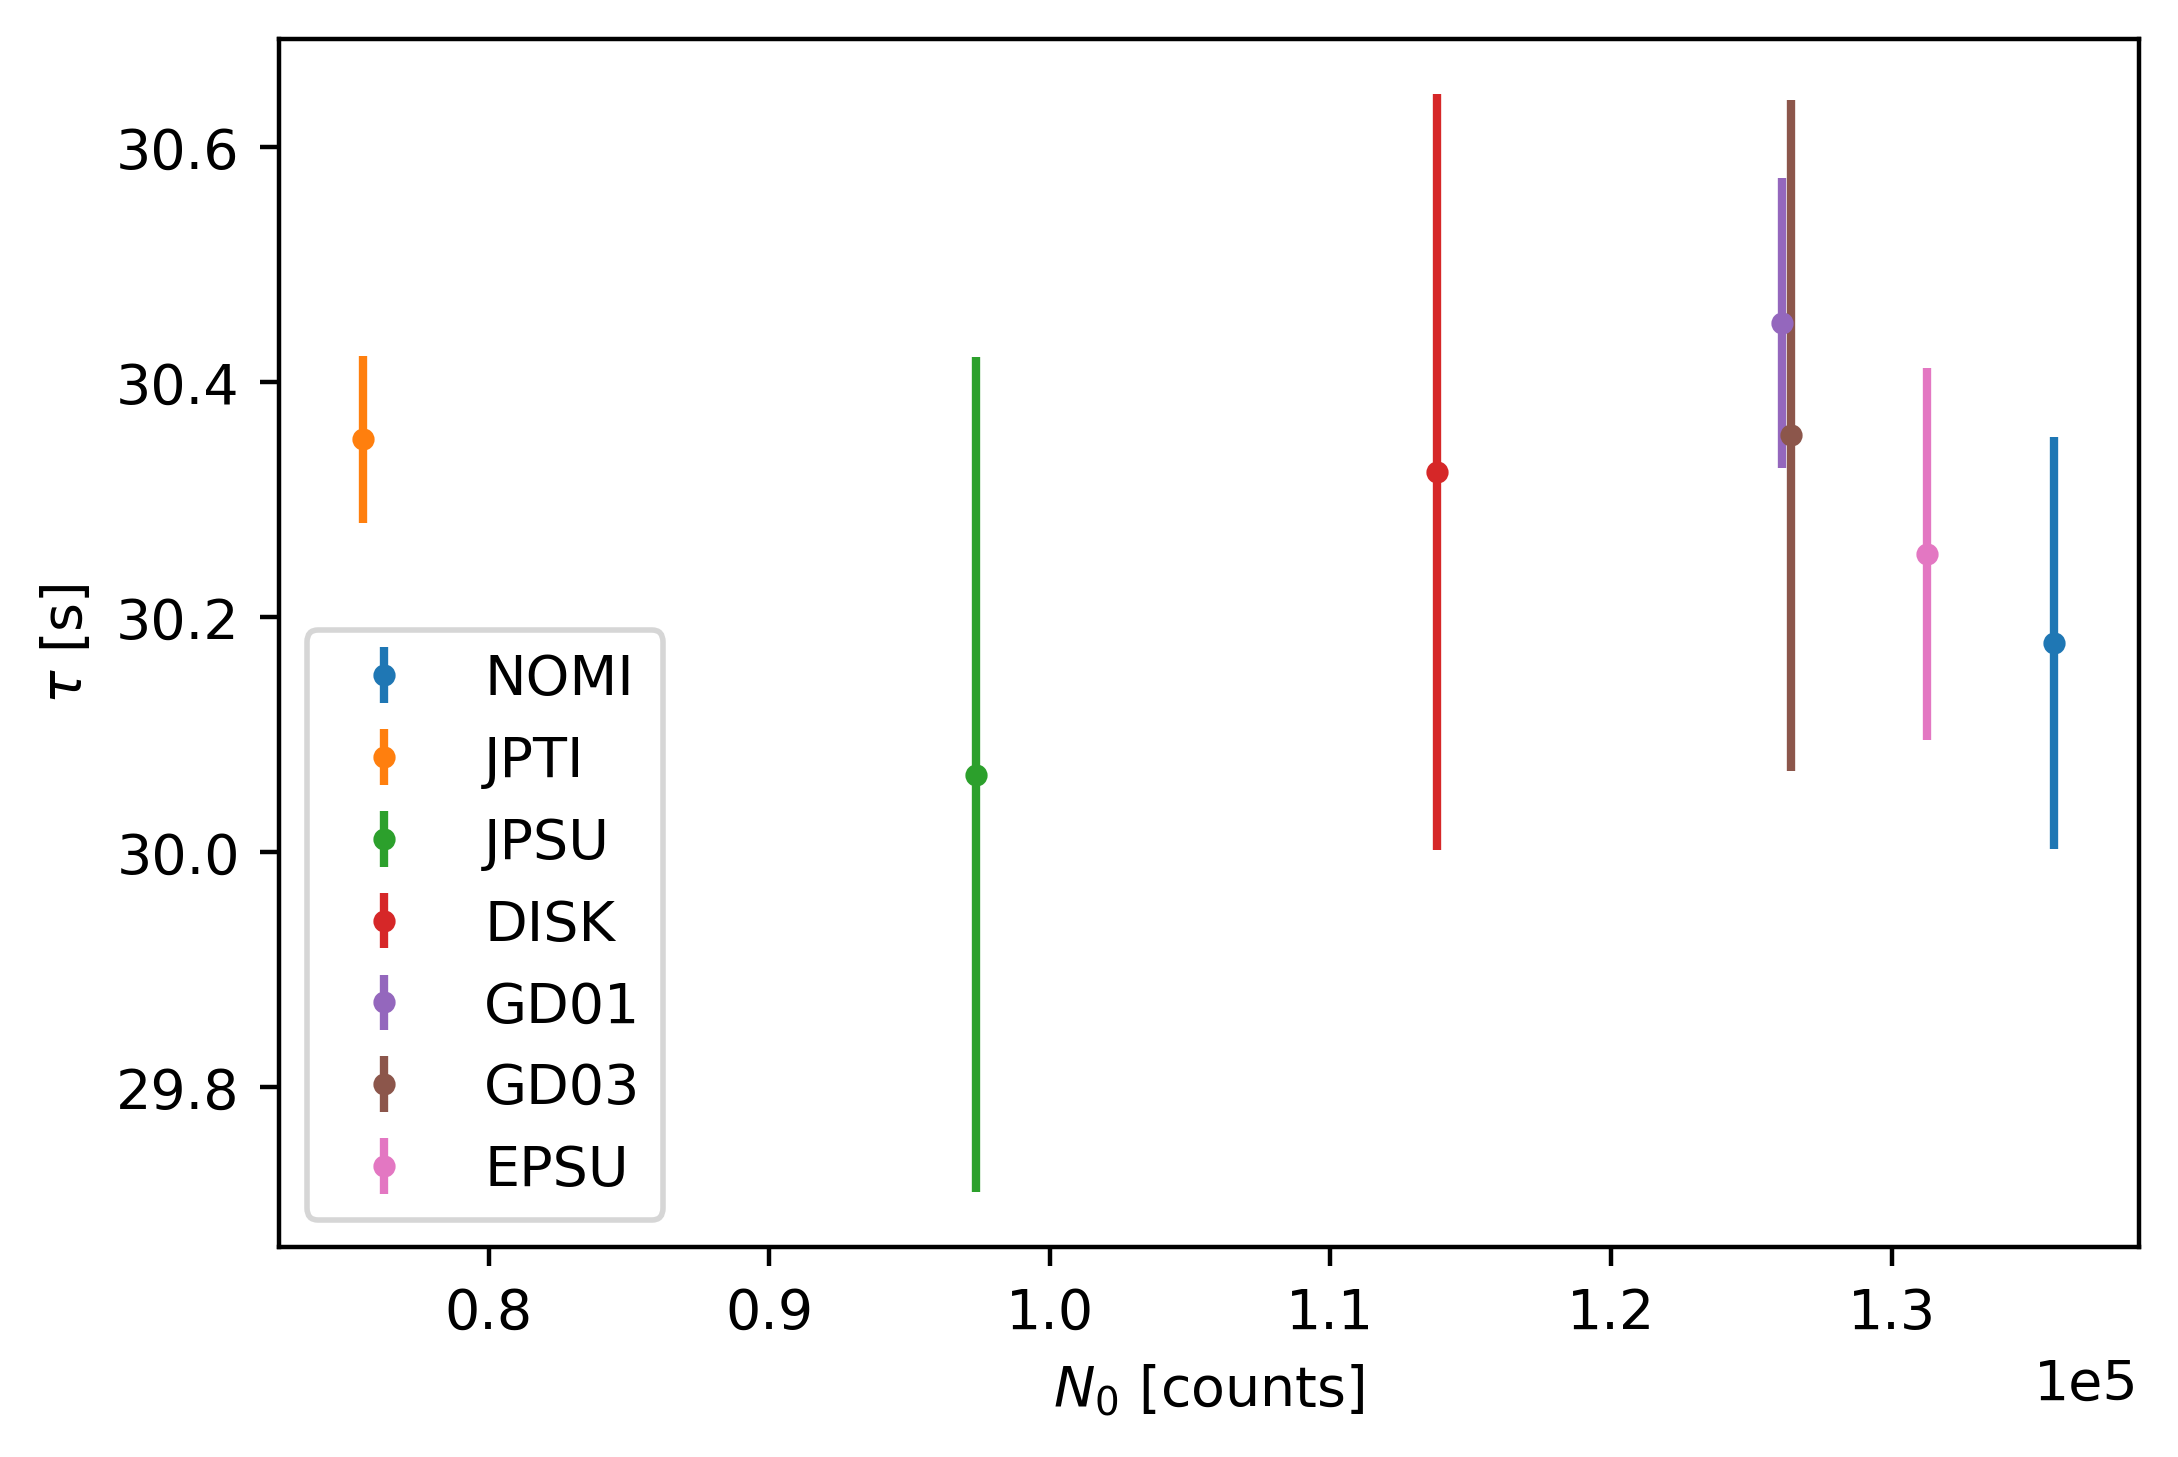

In [59]:
config_list = ['NOMI', 'JPTI', 'JPSU', 'DISK', 'GD01', 'GD03', 'EPSU']
run_type_list = ['s005', 's020', 's100']

fig, ax = plt.subplots()
ax = plt.gca()

fig_tau, ax_tau = plt.subplots()

# for counting loop iterations
text_y_coord = -0.2

# iterate over every configuration
for config in config_list:
    
    no_shot_data = np.empty((0,5), float)
    
    # update the plotting color
    color = next(ax._get_lines.prop_cycler)['color']
    
    # iterate over all three pre-storage measurement times
    for run_type in run_type_list:
        
        # grab the array of data for this configuration and pre-storage time
        arr = data_dict[config, run_type]
        
        # (!!!) average it into a single value
        # generate uncertainty array of the count data, calculate mean, add to dict
        uarr = unumpy.umatrix(arr[:,2], arr[:,3])
        N = uarr.mean(1)[0,0]
        print(N)
        
        if (run_type == 's005'):
            
            ax.errorbar(arr[:,1], arr[:,2], yerr = arr[:,3], fmt = '.',
                     label = config, color = color)
        
        else:
            
            ax.errorbar(arr[:,1], arr[:,2], yerr = arr[:,3], fmt = '.',
                     color = color)
            
        no_shot_data = np.append(no_shot_data, 
                    arr,
                    axis=0)
            
    # performing an exponential fit
    t      = no_shot_data[:,1]
    counts = no_shot_data[:,2]
    gmodel = Model(storage_lt_fit)
    params = gmodel.make_params(N_0=10000, tau=30)
    result = gmodel.fit(counts, params, t=t, weights = 1/no_shot_data[:,3])
    
    ax.plot(t, result.best_fit, color = color);
    
    # printing the fit results below the figure
    text_y_coord = text_y_coord - 0.1
    ax.text(0, text_y_coord, config 
            + r': $N_0 = $%.2e $\pm $ %.2e$, \quad \tau = $%.2f $ \pm $ %.2f s' % (
                decimal.Decimal(result.params['N_0'].value), 
                decimal.Decimal(result.params['N_0'].stderr),
                decimal.Decimal(result.params['tau'].value),
                decimal.Decimal(result.params['tau'].stderr)),
            transform=ax.transAxes);
    
    print(config + ': dof = {}, redchi = {}'.format(result.nfree, result.redchi))
    
    ax_tau.errorbar(result.params['N_0'].value, result.params['tau'].value, yerr = result.params['tau'].stderr, fmt = '.', label = config, color = color)
        
ax.set_ylabel('UCN Counts');
ax.set_xlabel('Pre-Storage Time [s]')
ax.legend();
ax.set_yscale('log')
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
fig.savefig('../img/storage_lifetime.pdf')

ax_tau.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax_tau.set_ylabel(r'$\tau$ [s]');
ax_tau.set_xlabel(r'$N_0$ [counts]')
ax_tau.legend();
fig_tau.savefig('../img/all_taus.pdf')

In [53]:
result.params['N_0'].value

131249.28847013498

We see a near agreement here between GD01 and GD03, which is to be expected since they are the same guide but with different polishing techniques. The relatively tight spread of the storage lifetime, $\tau$, is as expected, since the guide geometry and material should have little effect on this measurement.